# Prueba de FFT en audio

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import os
import os.path as path
from IPython.display import Audio
import librosa.display
import pandas as pd

%matplotlib inline

## Variables de Entorno
Estas tal vez irían mejor en un archivo de configuración?

In [3]:
INPUT_DIR = os.path.join(os.getcwd(), "input")

In [4]:
train_dir = path.join(INPUT_DIR, "audio_train")
train_files = [os.path.abspath(os.path.join(train_dir, file)) 
               for file in os.listdir(train_dir)]

In [45]:
class Sound:
    def __init__(self, fs = 44100, y = np.array([]), filename = None):
        self.filename = filename
        self.fs = fs
        self.y = self.y = np.array(y, float) # Para que librosa no se queje al graficar, a matplotlib le da igual
    
    def read_file(self):
        if self.filename is None:
            print("No hay un nombre de archivo definido para este sonido")
            return
        
        self.fs, self.y = wavfile.read(self.filename)
        self.y = np.array(self.y, float)
        
    def compute_ft(self):
        self.fty = np.fft.fft(self.y)
        
    def compute_spectrogram(self):
        self.f, self.t, self.sxx = spectrogram(self.y, self.fs, nperseg=300, noverlap=0)
        
    def play(self, how = "file"):
        if how == "file":
            audio = Audio(filename = self.filename, autoplay = True)
        elif how == "data":
            audio = Audio(data = self.y, rate = self.fs)
        else:
            print("Método de reproducción desconocido. Pruebe con 'file' o 'data'")
            audio = None
        
        return(audio)
    
    def plot_wave(self):
        plt.plot(self.y)
        
    def plot_ft(self):
        if not(hasattr(self, "fty")):
            self.compute_ft()

        frecs = np.linspace(0, 2*self.fs, len(self.y))
        plt.plot(frecs, abs(self.fty))
        plt.xlim(0,self.fs)
    
    def plot_spectrogram(self):
        if not(hasattr(self, "sxx")):
            self.compute_spectrogram()
            
        plt.imshow(np.log(self.sxx),
                   extent=(self.t[0], self.t[-1], self.f[0], self.f[-1]),
                   aspect=0.00011,
                   origin='lower',
                   interpolation=None)
        
    def plot_spectrogram_librosa(self):
        # Let's make and display a mel-scaled power (energy-squared) spectrogram
        S = librosa.feature.melspectrogram(self.y, sr=self.fs, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Make a new figure
        plt.figure(figsize=(12,4))

        # Display the spectrogram on a mel scale
        # sample rate and hop length parameters are used to render the time axis
        librosa.display.specshow(log_S, sr=self.fs, x_axis='time', y_axis='mel')

        # Put a descriptive title on the plot
        plt.title('mel power spectrogram')

        # draw a color bar
        plt.colorbar(format='%+02.0f dB')

        # Make the figure layout compact
        plt.tight_layout()
        
    
    def split_harmonic_percussive(self):
        self.y_harmonic, self.y_percussive = librosa.effects.hpss(self.y)
        
        harmonic_sound = Sound(self.fs, self.y_harmonic)
        percussive_sound = Sound(self.fs, self.y_percussive)
        return harmonic_sound, percussive_sound

In [46]:
def nuevo_sonido(i = None):
    i = i if isinstance(i, int) else np.random.randint(0, len(train_files))
    archivo = train_files[i]
    fs, y = wavfile.read(archivo)
    sound = Sound(fs, y, archivo)
    return(sound)

In [15]:
s = nuevo_sonido()

In [47]:
s.play()

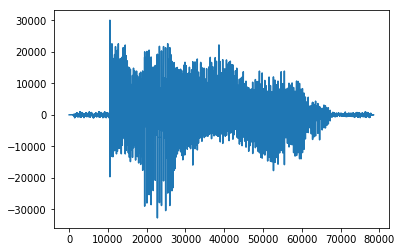

In [17]:
s.plot_wave()

In [18]:
s.compute_ft()

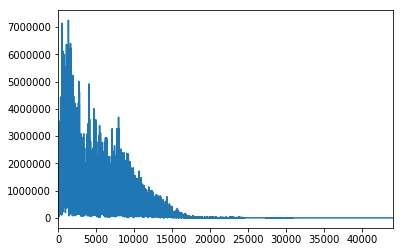

In [19]:
s.plot_ft()

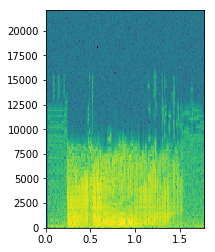

In [20]:
s.plot_spectrogram()

### Librosa
https://github.com/librosa/librosa

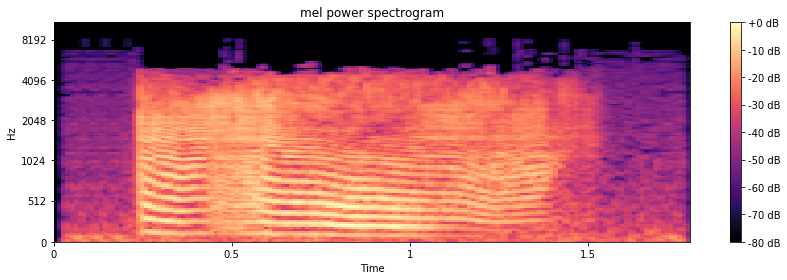

In [21]:
s.plot_spectrogram_librosa()

In [22]:
s_harmonico, s_percusivo = s.split_harmonic_percussive()

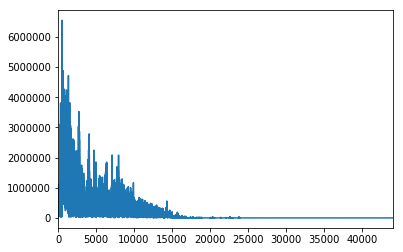

In [23]:
s_harmonico.plot_ft()

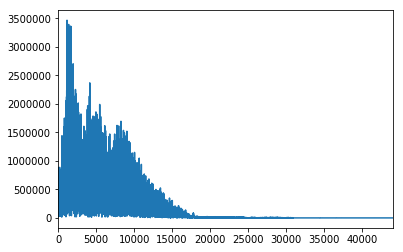

In [24]:
s_percusivo.plot_ft()

In [25]:
s_percusivo.play("data")

In [26]:
s_harmonico.play("data")

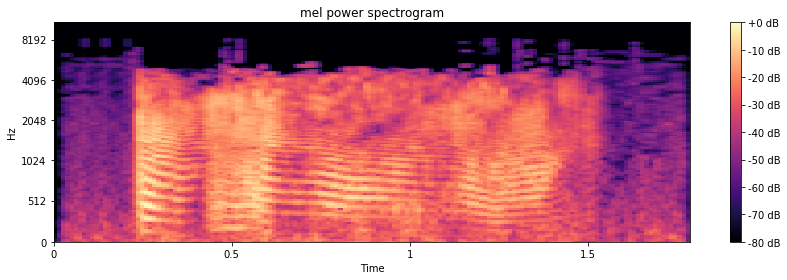

In [27]:
s_percusivo.plot_spectrogram_librosa()


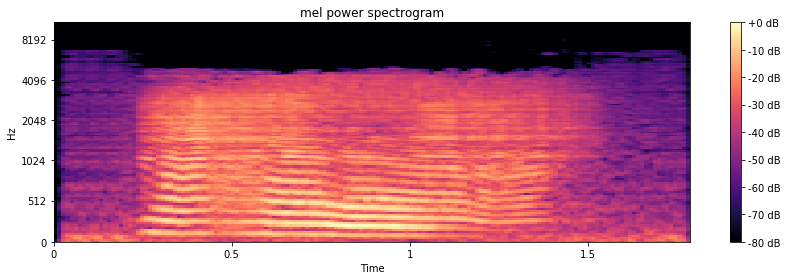

In [28]:
s_harmonico.plot_spectrogram_librosa()

In [48]:
df = pd.read_csv("input/train.csv")

In [49]:
df["filename"] = [os.path.join(train_dir, f) for f in df.fname]

In [50]:
def sample_label(df, label, n):
    sample_df = df[df.label == label].sample(n)

    for fname in sample_df.filename.get_values():
        print(fname)
        sound = Sound(filename = fname)
        sound.read_file()
        sound_h, sound_p = sound.split_harmonic_percussive()
#        sound.plot_spectrogram()
#        sound_h.plot_spectrogram_librosa()
        [x.plot_spectrogram_librosa() for x in [sound, sound_h, sound_p]]

/home/gonzalo/kaggle/fschallenge/input/audio_train/9c2ba819.wav
/home/gonzalo/kaggle/fschallenge/input/audio_train/ff875923.wav


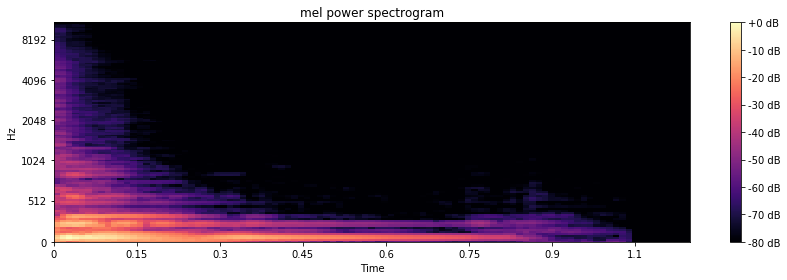

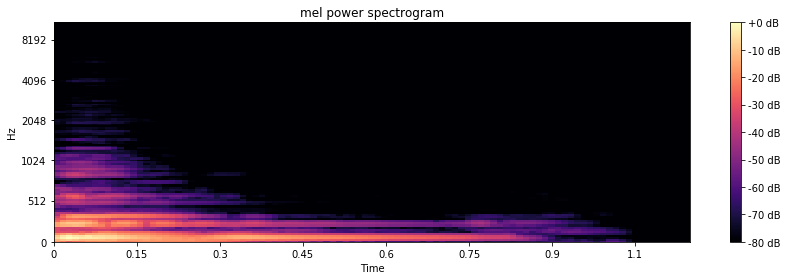

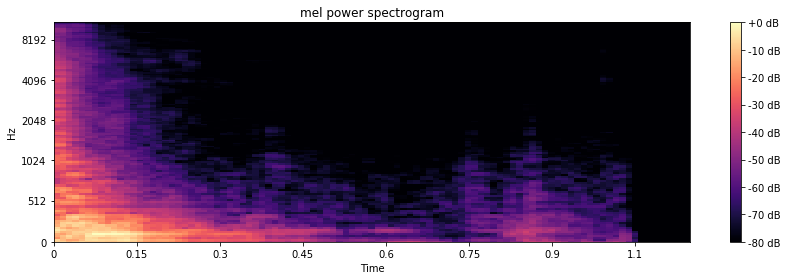

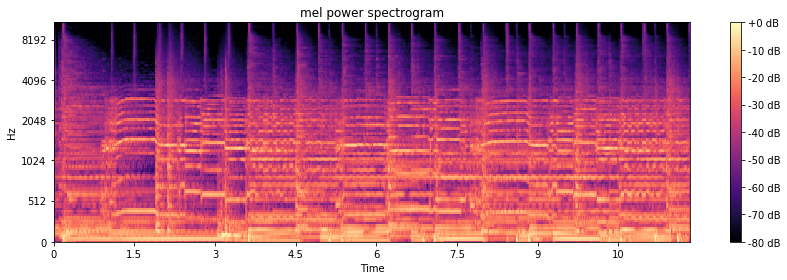

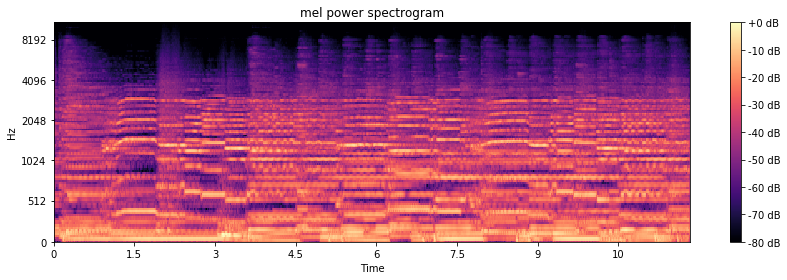

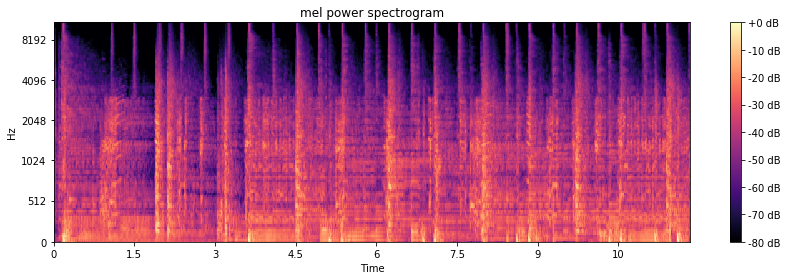

In [51]:
sample_label(df, "Cello", 2)